In [ ]:
### 역자 추가 코드
!pip install nltk==3.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1


In [ ]:
### 역자 추가 코드
# nltk 버전 출력
import nltk
print(nltk.__version__)

3.8.1


In [ ]:
### 역자 추가 코드
# NLTK 데이터 다운로드
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
### 역자 추가 코드
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install peft
!pip install bitsandbytes
!pip install sentencePiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 33.1 MB/s eta 0:00:00


# Handling Long Sequence by Chunking
## Plan
1. We will split the entire text into sentences.
2. Calculate the embedding of each sentence.
3. Calculate the whole text embedding by averaging the embeddings of each sentence.
4. Pass the whole text embedding to the fully connected layer for text classification.

## Data Preparation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
import nltk
from transformers import BertTokenizer, BertModel

# IMDB 데이터셋 준비
imdb_data = load_dataset('imdb')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer.pad_token = tokenizer.eos_token

class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_sentence_length=48):
        self.data = data
        self.tokenizer = tokenizer
        self.max_sentence_length = max_sentence_length

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        # text를 sentences로 분할
        sentences = nltk.sent_tokenize(text)
        # input_ids는 각 sentence의 `input_ids` 리스트임
        input_ids = [tokenizer.encode(sentence, max_length=self.max_sentence_length, truncation=True, padding='max_length') for sentence in sentences]
        # attention_masks는 각 sentence의 `attention_masks` 리스트임
        attention_masks = [[1 if token_id != tokenizer.pad_token_id else 0 for token_id in sentence] for sentence in input_ids]
        return {'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'attention_mask': torch.tensor(attention_masks, dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.long)}

# 전체 데이터셋의 10%를 학습에 적용
train_dataset = IMDBDataset(imdb_data['train'], tokenizer)
test_dataset = IMDBDataset(imdb_data['test'], tokenizer)

train_10_percent = int(len(train_dataset) * 0.1)
test_10_percent = int(len(test_dataset) * 0.1)

# 남은 90% 데이터셋 샘플 개수 계산
train_90_percent = len(train_dataset) - train_10_percent
test_90_percent = len(test_dataset) - test_10_percent

# 데이터셋을 10:90으로 분할
train_data_10_percent, _ = random_split(train_dataset, [train_10_percent, train_90_percent])
test_data_10_percent, _ = random_split(test_dataset, [test_10_percent, test_90_percent])





/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### pad_collate
**What we are doing here?**
If you choose a batch size of 4, Pytorch requires that the number of sentences in each sample for that batch should be the same. However, this is not the case in real life. In a batch of size 4, sample 1 could have 10 sentences, and sample 2 could have 13 sentences.

Therefore, in the pad_collate function, we perform padding on the sentences. We calculate the maximum number of sentences in that batch and pad accordingly.

In [ ]:

def pad_collate(batch):
    # 배치내 최대 sentence 수 계산
    max_num_sentences = max([item['input_ids'].shape[0] for item in batch])

    input_ids_batch = []
    attention_masks_batch = []

    # 배치별로 루프 실행. 만약 batch_size=4이면 4회 루프 실행
    for item in batch:
        num_sentences = item['input_ids'].shape[0]
        pad_length = max_num_sentences - num_sentences
        input_ids = torch.cat([item['input_ids'], torch.zeros(pad_length, item['input_ids'].shape[1], dtype=torch.long)], dim=0)
        attention_mask = torch.cat([item['attention_mask'], torch.zeros(pad_length, item['attention_mask'].shape[1], dtype=torch.long)], dim=0)

        input_ids_batch.append(input_ids)
        attention_masks_batch.append(attention_mask)

    # dim=0을 따라 스태킹(stacking)해서 리스트를 텐서로 변환
    input_ids_tensor = torch.stack(input_ids_batch, dim=0)
    attention_masks_tensor = torch.stack(attention_masks_batch, dim=0)
    labels_tensor = torch.tensor([item['label'] for item in batch], dtype=torch.long)

    return {'input_ids': input_ids_tensor, 'attention_mask': attention_masks_tensor, 'label': labels_tensor}

train_loader = DataLoader(train_data_10_percent, batch_size=4, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_data_10_percent, batch_size=4, shuffle=True, collate_fn=pad_collate)

In [ ]:
item=next(iter(train_loader))


### We are just looking at the shape of data.
1. This signifies that batch_size=4, max_sentences inthat batch=21, max_seq_len=48

In [ ]:
print('input_ids', item['input_ids'].shape)
print('attention_mask', item['attention_mask'].shape)
print('label', item['label'].shape)

input_ids torch.Size([4, 25, 48])
attention_mask torch.Size([4, 25, 48])
label torch.Size([4])


In [ ]:
print(item['input_ids'])

tensor([[[  101,  2296,  2028,  ..., 11092,  1037,   102],
         [  101,  2045,  2024,  ...,     0,     0,     0],
         [  101,  2000,  2228,  ...,     0,     0,     0],
         ...,
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]],

        [[  101,  2216,  2040,  ...,     0,     0,     0],
         [  101, 10805, 12413,  ...,     0,     0,     0],
         [  101, 27838, 14431,  ...,     0,     0,     0],
         ...,
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0],
         [    0,     0,     0,  ...,     0,     0,     0]],

        [[  101, 11011,  1010,  ...,     0,     0,     0],
         [  101,  1996,  2142,  ...,     0,     0,     0],
         [  101,  5814,  6088,  ...,     0,     0,     0],
         ...,
         [  101, 10556,  9759,  ...,     0,     0,     0],
         [

### Model Architecture
1. forward(self, input_ids_list, attention_mask_list): This method defines the forward pass of the neural network. It takes two arguments: input_ids_list and attention_mask_list, which are lists of input IDs and attention masks for each input sentence, respectively.

2. The nested loops iterate through the batches and sentences within the batches. For each sentence, the BERT model is applied, and the 'pooler_output' is extracted, which is a fixed-size representation of the input text. The pooled outputs for each sentence are then stacked into a single tensor and averaged along the first dimension.

3. The batch_pooled_outputs list is then converted into a tensor using torch.stack().


4. The final fully connected (linear) layer is applied to produce the classification logits.

5. The FineTunedBertClassifier class is designed to handle variable-length input sequences by processing them sentence by sentence and averaging their pooled outputs. This approach can handle different numbers of sentences per batch and allows the model to be fine-tuned on a specific classification task.

In [ ]:
class FineTunedBertClassifier(nn.Module):
    def __init__(self, n_classes):
        super(FineTunedBertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids_list, attention_mask_list):
        batch_pooled_outputs = []

        # 배치별로 루프 실행
        for batch_input_ids, batch_attention_mask in zip(input_ids_list, attention_mask_list):
            pooled_outputs = []

            # 샘플내 각 sentence에 대해 루프 실행
            # pooler_output은 sentence 표현형(representation)임. output['pooler_output']는 bert의 경우 sentence 임베딩임
            for input_ids, attention_mask in zip(batch_input_ids, batch_attention_mask):
                output = self.bert(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
                pooler_output = output['pooler_output']
                pooled_outputs.append(pooler_output)

            # pooled outputs를 단일 텐서로 스태킹
            pooled_outputs_tensor = torch.stack(pooled_outputs, dim=1)

            # 첫 번째 차원(dim=1)을 따라 평균 계산
            concatenated_output = torch.mean(pooled_outputs_tensor, dim=1)
            batch_pooled_outputs.append(concatenated_output)

        # batch_pooled_outputs을 단일 텐서로 스태킹
        batch_pooled_outputs_tensor = torch.stack(batch_pooled_outputs, dim=0)

        output = self.dropout(batch_pooled_outputs_tensor)

        output = torch.squeeze(output, dim=1)

        return self.fc(output)

The above code may looks confusing. Thus, lets understand through the example. It's important to understand that the following example is just to explain the architecture of model. Our IMDB data_set dimension is diffrent than following example.

1. Suppose, input_ids_list and attention_mask_list looks like below.
```
input_ids_list = [
    [  # sample 1
        [101, 2023, 2003, 1037, 2742, 102],  # Sentence 1: "This is a sample."
        [101, 1045, 2066, 2026, 3835, 102]   # Sentence 2: "I like my coffee."
    ],
    [  # sample 2
        [101, 1045, 2572, 1037, 3076, 102],  # Sentence 1: "I am a student."
        [101, 2026, 3899, 2003, 2307, 102]   # Sentence 2: "My dog is great."
    ]
]
```
```
attention_mask_list = [
    [  # sample 1
        [1, 1, 1, 1, 1, 1],  # Attention mask for sentence 1
        [1, 1, 1, 1, 1, 1]   # Attention mask for sentence 2
    ],
    [  # sample 2
        [1, 1, 1, 1, 1, 1],  # Attention mask for sentence 1
        [1, 1, 1, 1, 1, 1]   # Attention mask for sentence 2
    ]
]
```
2. pooled Output looks like


```
pooled_outputs = [
    [tensor_1_1],  # pooler_output for Batch 1, Sentence 1
    [tensor_1_2]   # pooler_output for Batch 1, Sentence 2
]

```
Here, tensor_1_1 and tensor_1_2 are tensors of shape (1, 768) representing the pooled outputs (fixed-size sentence embeddings) for the two sentences in the first batch.

When you execute pooled_outputs_tensor = torch.stack(pooled_outputs, dim=1), it stacks the pooled output tensors along dimension 1. The resulting pooled_outputs_tensor would have the shape (1, 2, 768):

```
[
    [
        [tensor_1_1],  # pooler_output for Batch 1, Sentence 1
        [tensor_1_2]   # pooler_output for Batch 1, Sentence 2
    ]
]

```
3.
In the example, the pooled_outputs_tensor has a shape of (1, 2, 768), where the first dimension corresponds to the batch, the second dimension corresponds to the sentences within the batch, and the third dimension corresponds to the hidden size of the BERT model's output.

The line concatenated_output = torch.mean(pooled_outputs_tensor, dim=1) computes the mean of the pooled_outputs_tensor along dimension 1 (i.e., the sentences dimension). By doing this, we are effectively averaging the sentence embeddings within each batch. The result is a single tensor representing the entire batch, with a shape of (1, 768).

In this specific example, the concatenated_output tensor would be:
```
[
    [tensor_mean_1]  # Mean of pooled_outputs for Batch 1 (shape: (1, 768))
]

```

4. batch_pooled_outputs


```
batch_pooled_outputs = [
    [tensor_mean_1],  # Averaged sentence representation for sample 1
    [tensor_mean_2]   # Averaged sentence representation for sample 2
]

```

5. Finally Batched Pooled Output is send to the fully connected layer of classification

In [ ]:
len(train_loader)

625

In [ ]:
# 유료 코랩 Colap PPO의 A100 GPU 설정에서 런타임 1시간 20분 소요
### 역자 주: 이하 코드는 무료 코랩에서는 램을 모두 소진하여 중간에 실행이 중단됩니다.
###        이를 방지하기 위해서는 유료 버전 코랩을 구독하거나, 사용자의 컴퓨터에서 주피터 노트북 환경으로 실행합니다.
###        아래 실행 결과는 유료 코랩 Colap PRO에서 A100 GPU 설정하에 실행한 결과입니다.
###        모델_save_path는 사용자 컴퓨터의 디렉토리 혹은 구글 드라이브 경로로 변경합니다.
###        코드 실행 전에 미리 구글 드라이브의 MyDrive 폴더 하위에 Book6 > Ch6 > model 디렉토리를 순차적으로 생성해야 합니다.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from accelerate import Accelerator
from tqdm import tqdm

accelerator = Accelerator()
device = accelerator.device

model = FineTunedBertClassifier(n_classes=2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

model, optimizer = accelerator.prepare(model, optimizer)

criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
# 모델을 100회 배치마다 저장
# 이는 시스템 failure 등으로 연산이 중단됐을 경우, 연산이 중단된 그 장소에서 재시동 가능
# save interval은 여러분의 필요에 따라 조정 가능
save_interval=100

# 학습 루프
### 역자 주: 실행 시간이 우려되는 경우 num_epochs를 1로 설정합니다.
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    train_loader_progress = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}, Training", total=len(train_loader))
    for batch_idx, batch in train_loader_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        accelerator.backward(loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        if batch_idx % 10 == 0:
            train_loader_progress.set_postfix(loss=loss.item())
        if (batch_idx + 1) % save_interval == 0:
            model_save_path = f"/content/drive/MyDrive/Book6/Ch6/model/AlbertTextClassifier_epoch{epoch + 1}_batch{batch_idx + 1}.pt"
            torch.save(model.state_dict(), model_save_path)
    model.eval()
    total_correct = 0
    total_samples = 0
    test_loader_progress = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs}, Testing")

    with torch.no_grad():
        for batch in test_loader_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.4f}")

Epoch 1/3, Testing: 100%|██████████| 625/625 [06:45<00:00,  1.54it/s]


Epoch 1/3, Accuracy: 0.8840


Epoch 2/3, Testing: 100%|██████████| 625/625 [06:48<00:00,  1.53it/s]


Epoch 2/3, Accuracy: 0.8796


Epoch 3/3, Testing: 100%|██████████| 625/625 [06:48<00:00,  1.53it/s]

Epoch 3/3, Accuracy: 0.8344


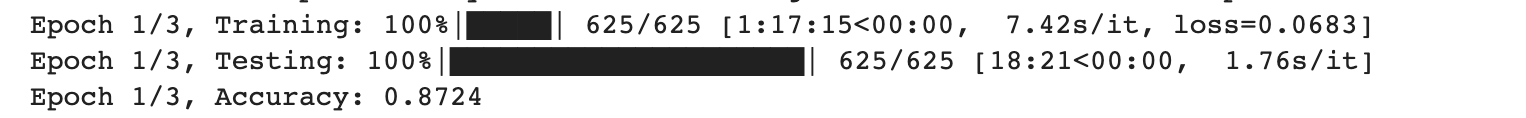

#Analysis
This is awesome. With just 10% of the dataset and only 1 epoch, we obtained an accuracy of 87%. I think the maximum accuracy for the IMDB dataset is around 96%. You could train the above model with the full dataset and a larger number of epochs to get even better result.

# Hierirchal Attention
## Plan
1. Hierarchical attention: This model uses a two-level hierarchical attention mechanism:
  * Local attention: Applied to individual sentences in a document to create sentence representations.
  * Global attention: Applied to sentence representations to create a document representation.


## Data preparation
The data preparation is exactly similar to data preparation we did above.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
import nltk
from transformers import BertTokenizer, BertModel

# IMDB 데이터셋 준비
imdb_data = load_dataset('imdb')

from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

class IMDBDataset(Dataset):
    def __init__(self, data, tokenizer, max_sentence_length=48):
        self.data = data
        self.tokenizer = tokenizer
        self.max_sentence_length = max_sentence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        sentences = nltk.sent_tokenize(text)
        input_ids = [tokenizer.encode(sentence, max_length=self.max_sentence_length, truncation=True, padding='max_length') for sentence in sentences]
        attention_masks = [[1 if token_id != tokenizer.pad_token_id else 0 for token_id in sentence] for sentence in input_ids]
        return {'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'attention_mask': torch.tensor(attention_masks, dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.long)}

train_dataset = IMDBDataset(imdb_data['train'], tokenizer)
test_dataset = IMDBDataset(imdb_data['test'], tokenizer)

train_5_percent = int(len(train_dataset) * 0.05)
test_5_percent = int(len(test_dataset) * 0.05)

# 남은 95%에 대한 샘플 수 계산
train_95_percent = len(train_dataset) - train_5_percent
test_95_percent = len(test_dataset) - test_5_percent

# 데이터셋을 5:95로 분할
train_data_5_percent, _ = random_split(train_dataset, [train_5_percent, train_95_percent])
test_data_5_percent, _ = random_split(test_dataset, [test_5_percent, test_95_percent])

def pad_collate(batch):
    max_num_sentences = max([item['input_ids'].shape[0] for item in batch])

    input_ids_batch = []
    attention_masks_batch = []

    for item in batch:
        num_sentences = item['input_ids'].shape[0]
        pad_length = max_num_sentences - num_sentences
        input_ids = torch.cat([item['input_ids'], torch.zeros(pad_length, item['input_ids'].shape[1], dtype=torch.long)], dim=0)
        attention_mask = torch.cat([item['attention_mask'], torch.zeros(pad_length, item['attention_mask'].shape[1], dtype=torch.long)], dim=0)

        input_ids_batch.append(input_ids)
        attention_masks_batch.append(attention_mask)

    input_ids_tensor = torch.stack(input_ids_batch, dim=0)
    attention_masks_tensor = torch.stack(attention_masks_batch, dim=0)
    labels_tensor = torch.tensor([item['label'] for item in batch], dtype=torch.long)

    return {'input_ids': input_ids_tensor, 'attention_mask': attention_masks_tensor, 'label': labels_tensor}

train_loader = DataLoader(train_data_5_percent, batch_size=2, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_data_5_percent, batch_size=2, shuffle=True, collate_fn=pad_collate)



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
len(train_loader)

625

## 2.2. Model Architecture

In [ ]:
from transformers import AlbertModel

class AlbertTextClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AlbertTextClassifier, self).__init__()
        self.albert = AlbertModel.from_pretrained("albert-base-v2")
        self.attention = nn.Linear(self.albert.config.hidden_size, 1)
        self.classifier = nn.Linear(self.albert.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        batch_size, num_sentences, seq_len = input_ids.shape
        input_ids = input_ids.view(batch_size * num_sentences, seq_len)
        attention_mask = attention_mask.view(batch_size * num_sentences, seq_len)

        outputs = self.albert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        attention_weights = torch.softmax(
            self.attention(hidden_states), dim=1)
        sentence_representation = torch.sum(attention_weights * hidden_states, dim=1)
        sentence_representation = sentence_representation.view(batch_size, num_sentences, -1)

        doc_attention_weights = torch.softmax(self.attention(sentence_representation), dim=1)
        doc_representation = torch.sum(doc_attention_weights * sentence_representation, dim=1)
        doc_representation = self.dropout(doc_representation)  # Add dropout

        logits = self.classifier(doc_representation)
        return logits


###The above code might be confusing: Let's explain through example:
Assume we have the following input:

  * 2 documents (batch_size = 2)
  * Each document has 3 sentences (num_sentences = 3)
  * Each sentence has 4 tokens (seq_len = 4)
  * The input data would have the following dimensions:
  ```
  input_ids: (2, 3, 4)
  attention_mask: (2, 3, 4)
  ```
Now, let's walk through the processing steps:

1. Reshape input_ids and attention_mask:
  ```
  input_ids: (6, 4) [2 * 3 = 6, #since we have 2 documents with 3 sentences each]
  attention_mask: (6, 4)
  ```
2. Pass input_ids and attention_mask to the ALBERT model:

  * Obtain hidden_states with dimensions (6, 4, hidden_size)
  * Compute attention weights for each token:

3. Apply self.attention to hidden_states, resulting in a tensor of shape (6, 4, 1)
4. Apply softmax to compute attention_weights: (6, 4, 1)
5. Calculate sentence representations:

  * Multiply attention_weights with hidden_states (element-wise): (6, 4, hidden_size)
  * Sum along the sequence dimension (dim=1): (6, hidden_size)
  * Reshape the tensor to (2, 3, hidden_size)

6. Compute document-level attention weights:

  * Apply self.attention to sentence_representation, resulting in a tensor of shape (2, 3, 1)
  * Apply softmax to compute doc_attention_weights: (2, 3, 1)
7. Calculate document representations:

  * Multiply doc_attention_weights with sentence_representation (element-wise): (2, 3, hidden_size)
  * Sum along the sentences dimension (dim=1): (2, hidden_size)
  * Apply dropout to the document representations:

8. doc_representation: (2, hidden_size)
9. Pass the document representation through the classifier layer:


## 2.3. Training loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from accelerate import Accelerator
from tqdm import tqdm

accelerator = Accelerator()
device = accelerator.device

model = AlbertTextClassifier(num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

model, optimizer = accelerator.prepare(model, optimizer)

criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
save_interval=100

# 학습 루프
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_loader_progress = tqdm(enumerate(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}, Training", total=len(train_loader))
    for batch_idx, batch in train_loader_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        accelerator.backward(loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        if batch_idx % 10 == 0:
            train_loader_progress.set_postfix(loss=loss.item())
        if (batch_idx + 1) % save_interval == 0:
            model_save_path = f"/content/drive/MyDrive/Book6/Ch6/model/AlbertTextClassifier_epoch{epoch + 1}_batch{batch_idx + 1}.pt"
            torch.save(model.state_dict(), model_save_path)
    model.eval()
    total_correct = 0
    total_samples = 0
    test_loader_progress = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs}, Testing")

    with torch.no_grad():
        for batch in test_loader_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy:.4f}")

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Epoch 1/1, Testing: 100%|██████████| 625/625 [00:22<00:00, 28.27it/s]

Epoch 1/1, Accuracy: 0.8352


원 자저는 약 86%의 추론 정확도를 얻었으며
역자가 크드를 실행한 이 노트북에서는 약 83.5%의 정확도를 얻었습니다.

딥러닝에서는 매번 실행시마다 미세하게 결과가 달라질 수 있습니다.

It's awesome, we obtained 86% accuracy which is similar to document chuncking approach